## Data Loading

In [55]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [56]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, 'data/')

Using downloaded and verified file: data/cifar10.tgz


In [57]:
# Extract from archive
with tarfile.open('data/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [58]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


In [59]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [60]:
train_ds = ImageFolder(data_dir+'/train', transform=ToTensor())

In [61]:
image, label = train_ds[0]

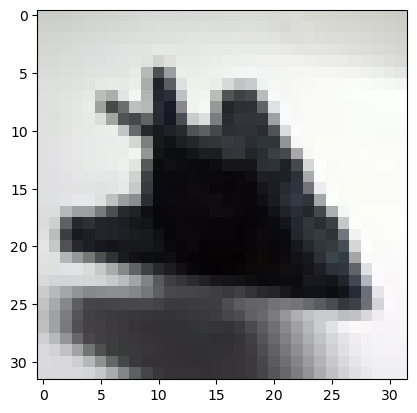

In [62]:
plt.imshow(image.permute(1, 2, 0))

In [63]:
print(image.shape, label)

torch.Size([3, 32, 32]) 0


In [64]:
train_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [65]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  dog (5)


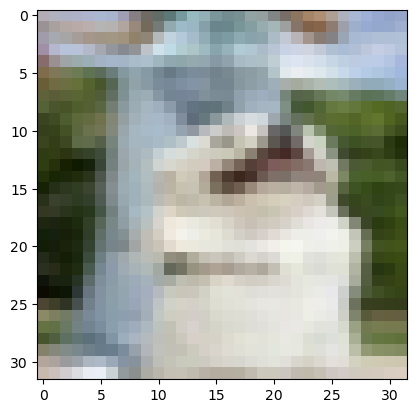

In [66]:
show_example(*train_ds[27821])

In [67]:
random_seed = 43
torch.manual_seed(random_seed)

In [68]:
val_size = 10_000
train_size = len(train_ds) - val_size

In [69]:
from torch.utils.data import DataLoader


In [70]:
train_ds, val_ds = random_split(dataset=train_ds, lengths=[train_size, val_size])

In [71]:
train_loader = DataLoader(dataset=train_ds,
                          batch_size=128,
                          shuffle=True)

val_loader = DataLoader(dataset=val_ds,
                        batch_size=128)

In [72]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots()
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

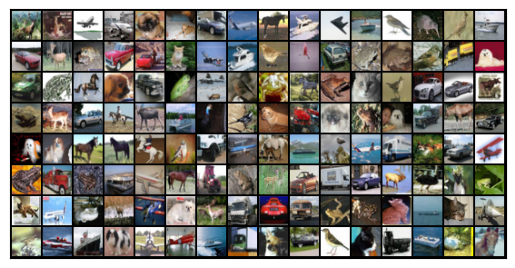

In [38]:
show_batch(train_loader)

## Convulating (Literally!)
https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

There are certain advantages offered by convolutional layers when working with image data:

Fewer parameters: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.

Sparsity of connections: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.

Parameter sharing and spatial invariance: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a max-pooling layers to progressively decrease the height & width of the output tensors from each convolutional layer.

In [39]:
import torch.nn as nn
import torch.nn.functional as F

In [40]:
simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

In [42]:
for images, labels in train_loader:
    print(images.shape)
    out = simple_model(images)
    print(out.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 8-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [43]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [44]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, xb):
        return self.network(xb)


In [45]:
model = CIFAR10Model()

In [47]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval() # model is in evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() # model now in training mode
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [50]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func=opt_func)

Epoch [0], train_loss: 1.7166, val_loss: 1.3631, val_acc: 0.4975
Epoch [1], train_loss: 1.2111, val_loss: 1.0682, val_acc: 0.6128
Epoch [2], train_loss: 0.9248, val_loss: 0.8608, val_acc: 0.6956
Epoch [3], train_loss: 0.7175, val_loss: 0.7600, val_acc: 0.7344
Epoch [4], train_loss: 0.5701, val_loss: 0.7315, val_acc: 0.7495
Epoch [5], train_loss: 0.4356, val_loss: 0.7788, val_acc: 0.7492
Epoch [6], train_loss: 0.3195, val_loss: 0.7547, val_acc: 0.7668
Epoch [7], train_loss: 0.2261, val_loss: 0.8746, val_acc: 0.7564
Epoch [8], train_loss: 0.1677, val_loss: 0.9582, val_acc: 0.7565
Epoch [9], train_loss: 0.1388, val_loss: 1.1235, val_acc: 0.7607


In [51]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

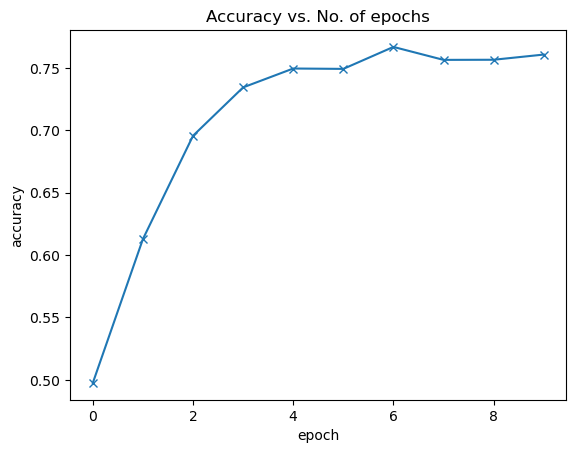

In [52]:
plot_accuracies(history)

In [53]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

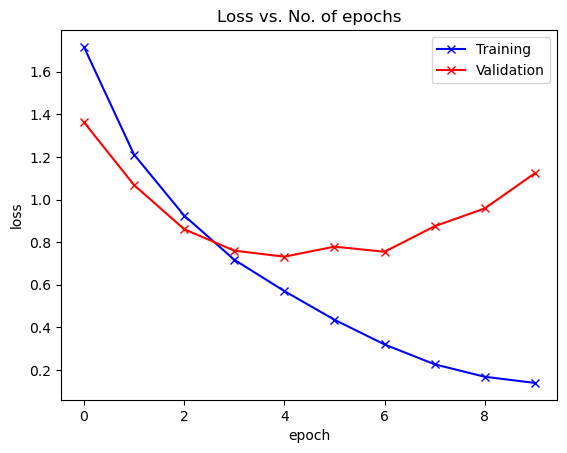

In [54]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase